In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.0002
num_epochs = 50
latent_size = 100
num_classes = 10
image_size = 784  # 28x28
embedding_size = 10  # Size of the embedding vector

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_size)
        self.model = nn.Sequential(
            nn.Linear(image_size + embedding_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        x = x.view(x.size(0), -1)  # Reshape x to [batch_size, image_size]

        label_embedding = self.label_embedding(labels)
        x = torch.cat([x, label_embedding], 1)  # Concatenate along dimension 1
        output = self.model(x)
        return output

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, embedding_size)
        self.model = nn.Sequential(
            nn.Linear(latent_size + embedding_size, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        z = torch.cat([z, label_embedding], 1)
        output = self.model(z)
        return output.view(-1, 1, 28, 28)

# Initialize models
D = Discriminator().to(device)
G = Generator().to(device)

# Loss and optimizer
criterion = nn.BCELoss()
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate)
g_optimizer = optim.Adam(G.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        current_batch_size = images.size(0)

        # Prepare real images and labels
        real_images = images.view(current_batch_size, -1).to(device)
        real_labels = torch.ones(current_batch_size, 1).to(device)
        labels = labels.to(device).long()

        # Generate fake images
        z = torch.randn(current_batch_size, latent_size).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        fake_images = G(z, labels)

        # Discriminator loss for real images
        outputs_real = D(real_images, labels)
        d_loss_real = criterion(outputs_real, real_labels)

        # Discriminator loss for fake images
        outputs_fake = D(fake_images.detach(), labels)
        d_loss_fake = criterion(outputs_fake, fake_labels)

        # Calculate total discriminator loss and backpropagate
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator loss
        outputs = D(fake_images, labels)
        g_loss = criterion(outputs, real_labels)

        # Backpropagate for generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print status
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')


100%|██████████| 9912422/9912422 [00:00<00:00, 105977490.19it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 105335385.93it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 30847523.58it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6477568.44it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/50], Step [100/938], d_loss: 0.4271, g_loss: 1.6275
Epoch [1/50], Step [200/938], d_loss: 0.2562, g_loss: 1.6991
Epoch [1/50], Step [300/938], d_loss: 0.1881, g_loss: 7.9797
Epoch [1/50], Step [400/938], d_loss: 0.0155, g_loss: 5.3311
Epoch [1/50], Step [500/938], d_loss: 0.0035, g_loss: 7.3196
Epoch [1/50], Step [600/938], d_loss: 0.0037, g_loss: 6.3213
Epoch [1/50], Step [700/938], d_loss: 0.0045, g_loss: 6.1209
Epoch [1/50], Step [800/938], d_loss: 0.0093, g_loss: 6.0019
Epoch [1/50], Step [900/938], d_loss: 0.0014, g_loss: 7.1510
Epoch [2/50], Step [100/938], d_loss: 0.0843, g_loss: 8.3808
Epoch [2/50], Step [200/938], d_loss: 0.0017, g_loss: 8.1877
Epoch [2/50], Step [300/938], d_loss: 0.0004, g_loss: 8.1568
Epoch [2/50], Step [400/938], d_loss: 0.0101, g_loss: 6.8801
Epoch [2/50], Step [500/938], d_loss: 0.0046, g_loss: 6.6825
Epoch [2/50], Step [600/938], d_loss: 0.0285, g_loss: 8.9066
Epoch [2/5

In [40]:
train_dataset[0][0].view(1, -1).shape

torch.Size([1, 784])

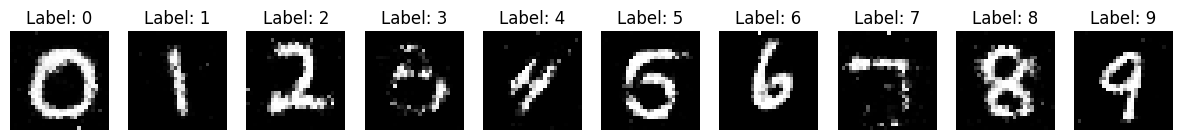

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to generate
num_images = 10

# Generate random noise
z = torch.randn(num_images, latent_size).to(device)

# Specify labels (0 to 9)
labels = torch.tensor([i for i in range(num_images)]).to(device)

# Generate images
with torch.no_grad():
    generated_images = G(z, labels).cpu().view(num_images, 28, 28)

# Plot the images along with their labels
plt.figure(figsize=(15, 3))
for i, image in enumerate(generated_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image.detach().numpy(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')  # Display the label above each image
    plt.axis('off')
plt.show()

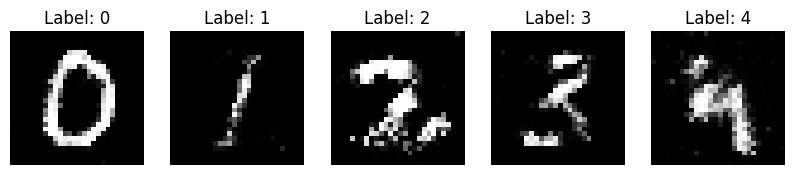

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to generate
num_images = 5

# Generate random noise
z = torch.randn(num_images, latent_size).to(device)

# Specify labels (for example: 0, 1, 2, 3, 4)
labels = torch.tensor([0, 1, 2, 3, 4]).to(device)

# Generate images
with torch.no_grad():
    generated_images = G(z, labels).cpu().view(num_images, 28, 28)

# Plot the images along with their labels
plt.figure(figsize=(10, 2))
for i, image in enumerate(generated_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image.detach().numpy(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.show()

#Do myself

In [3]:
import tensorflow as tf
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [5]:
x_train.shape, y_train.shape

((60000, 28, 28, 1), (60000,))

In [6]:
#reshape the data into (60000, 784)
X_train = x_train.reshape(x_train.shape[0], -1)

# Create the DataLoader
dataloader = DataLoader(
    dataset = list(zip(X_train, y_train)),
    batch_size = 64,
    shuffle = True
)

train_data = 0
train_label = 0
for data, label in dataloader:
  train_data+= data.shape[0]
  train_label+= label.shape[0]


print("Total train data # {} ".format(train_data))
print("Total train label # {} ".format(train_label))

Total train data # 60000 
Total train label # 60000 


In [7]:
# Create the Discriminator NN

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(784 + 10, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
      label_embedding = self.label_embedding(labels)
      x = torch.cat([x, label_embedding], 1)  # Concatenate along dimension 1
      output = self.model(x)
      return output

In [30]:
d = Discriminator().to(device)

In [15]:
# Create Generator

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_embedding = nn.Embedding(10, 10)
        self.model = nn.Sequential(
            nn.Linear(100 + 10, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        label_embedding = self.label_embedding(labels)
        z = torch.cat([z, label_embedding], 1)
        output = self.model(z)
        return output

In [29]:
g = Generator().to(device)

In [17]:
data = torch.randn(64, 100)
labels = torch.randint(low = 0, high = 10, size = (64, ))

g(data, labels).shape

torch.Size([64, 784])

In [18]:
torch.randint(low = 0, high = 10, size = (64,))

tensor([1, 9, 6, 5, 3, 9, 5, 3, 7, 3, 6, 2, 9, 4, 5, 4, 9, 6, 4, 7, 0, 8, 5, 3,
        9, 7, 8, 1, 6, 7, 4, 4, 9, 4, 0, 8, 3, 3, 6, 5, 4, 1, 7, 5, 3, 6, 5, 0,
        7, 1, 1, 5, 3, 8, 4, 9, 8, 6, 9, 3, 7, 6, 8, 6])

In [23]:
loss = nn.BCELoss()
d_optimizer = optim.Adam(d.parameters(), lr=0.0002)
g_optimizer = optim.Adam(g.parameters(), lr=0.0002)

In [25]:
fake_samples = torch.randn(64, 100)
g(fake_samples, labels).shape

torch.Size([64, 784])

In [28]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device

device(type='cuda')

In [72]:
for epoch in range(50):
    d_loss = []
    g_loss = []
    for (real_samples, labels) in dataloader:
        batch_size = real_samples.shape[0]

        # Prepare real data and labels
        real_data = real_samples.float().to(device)
        real_labels = torch.ones(batch_size, 1).to(device)
        labels = labels.long().to(device)

        # Generate fake data and labels
        fake_noise = torch.randn(batch_size, 100).to(device)
        fake_samples = g(fake_noise, labels).float().to(device)  # Assuming generator 'g' takes only noise as input
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train the discriminator
        real_predict = d(real_data, labels)
        real_loss = loss(real_predict, real_labels)

        fake_predict = d(fake_samples, labels)  # Assuming same labels are used for fake samples
        fake_loss = loss(fake_predict, fake_labels)

        total_d_loss = real_loss + fake_loss

        d_optimizer.zero_grad()
        total_d_loss.backward(retain_graph = True)
        d_optimizer.step()

        d_loss.append(total_d_loss.item())

        # Generator
        fake_predicted = d(fake_samples, labels)
        fake_loss_compute = loss(fake_predicted, real_labels)

        g_optimizer.zero_grad()
        fake_loss_compute.backward(retain_graph = True)
        g_optimizer.step()
        g_loss.append(fake_loss_compute.item())



    print("Epoch: {}/{} - d_loss: {} - g_loss:{}".format(epoch, 500,
                                                           np.array(d_loss).mean(),
                                                           np.array(g_loss).mean()))



Epoch: 0/500 - d_loss: 1.3938864150535324 - g_loss:0.6961554922401778
Epoch: 1/500 - d_loss: 1.3938941604801331 - g_loss:0.6961475247894523
Epoch: 2/500 - d_loss: 1.393896661968882 - g_loss:0.6961439858748715
Epoch: 3/500 - d_loss: 1.3938953571482253 - g_loss:0.6961460999969734
Epoch: 4/500 - d_loss: 1.3938874471416351 - g_loss:0.6961540163580034
Epoch: 5/500 - d_loss: 1.3938944729914797 - g_loss:0.6961458177963046
Epoch: 6/500 - d_loss: 1.3938876976336498 - g_loss:0.6961540422841176
Epoch: 7/500 - d_loss: 1.393895854192502 - g_loss:0.6961452584785185
Epoch: 8/500 - d_loss: 1.3938962048304868 - g_loss:0.696146506045673
Epoch: 9/500 - d_loss: 1.3938916325569153 - g_loss:0.6961489833240062
Epoch: 10/500 - d_loss: 1.3938944427443465 - g_loss:0.696146314332226
Epoch: 11/500 - d_loss: 1.3938925163323945 - g_loss:0.6961482864325997
Epoch: 12/500 - d_loss: 1.3938915519826194 - g_loss:0.696147443516168
Epoch: 13/500 - d_loss: 1.3939020791287615 - g_loss:0.6961395161619572
Epoch: 14/500 - d_los

In [83]:
# Training loop
for epoch in range(50):
    for i, (images, labels) in enumerate(dataloader):
        current_batch_size = images.size(0)

        # Prepare real images and labels
        real_images = images.to(device).float()
        real_labels = torch.ones(current_batch_size, 1).to(device)
        labels = labels.to(device).long()

        # Generate fake images
        z = torch.randn(current_batch_size, 100).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
        fake_images = g(z, labels)

        # Discriminator loss for real images
        outputs_real = d(real_images, labels)
        d_loss_real = loss(outputs_real, real_labels)

        # Discriminator loss for fake images
        outputs_fake = d(fake_images.detach(), labels)
        d_loss_fake = loss(outputs_fake, fake_labels)

        # Calculate total discriminator loss and backpropagate
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator loss
        outputs = d(fake_images, labels)
        g_loss = loss(outputs, real_labels)

        # Backpropagate for generator
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Print status
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{50}], Step [{i+1}/{len(dataloader)}], '
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}')


Epoch [1/50], Step [100/938], d_loss: 1.3935, g_loss: 0.6960
Epoch [1/50], Step [200/938], d_loss: 1.3940, g_loss: 0.6954
Epoch [1/50], Step [300/938], d_loss: 1.3940, g_loss: 0.6971
Epoch [1/50], Step [400/938], d_loss: 1.3922, g_loss: 0.6963
Epoch [1/50], Step [500/938], d_loss: 1.3937, g_loss: 0.6961
Epoch [1/50], Step [600/938], d_loss: 1.3924, g_loss: 0.6973
Epoch [1/50], Step [700/938], d_loss: 1.3949, g_loss: 0.6965
Epoch [1/50], Step [800/938], d_loss: 1.3946, g_loss: 0.6955
Epoch [1/50], Step [900/938], d_loss: 1.3933, g_loss: 0.6965
Epoch [2/50], Step [100/938], d_loss: 1.3940, g_loss: 0.6959
Epoch [2/50], Step [200/938], d_loss: 1.3930, g_loss: 0.6967
Epoch [2/50], Step [300/938], d_loss: 1.3934, g_loss: 0.6965
Epoch [2/50], Step [400/938], d_loss: 1.3925, g_loss: 0.6974
Epoch [2/50], Step [500/938], d_loss: 1.3929, g_loss: 0.6968
Epoch [2/50], Step [600/938], d_loss: 1.3965, g_loss: 0.6961
Epoch [2/50], Step [700/938], d_loss: 1.3938, g_loss: 0.6959
Epoch [2/50], Step [800/

In [51]:
target_class = 10
labels = torch.randint(low = 0, high = 10, size = (20, ), dtype = torch.long).to(device)

In [48]:
labels.dtype

torch.int64

In [50]:
images = torch.randn(20, 100).to(device)
images.dtype

torch.float32

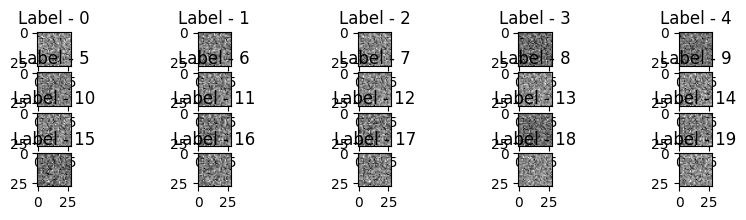

In [68]:
import matplotlib.pyplot as plt
index = 0
plt.figure(figsize=(10, 2))
for label, image in enumerate(g(images, labels)):
  image = image.reshape(28, 28, 1)
  plt.subplot(4, 5, index + 1)
  plt.imshow(image.cpu().detach().numpy(), cmap = "gray")
  plt.title("Label - {}".format(label))
  index = index + 1

plt.show()

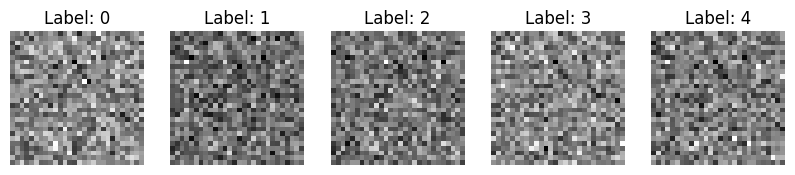

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to generate
num_images = 5

# Generate random noise
z = torch.randn(5, 100).to(device)

# Specify labels (for example: 0, 1, 2, 3, 4)
labels = torch.tensor([0, 1, 2, 3, 4]).to(device)

# Generate images
with torch.no_grad():
    generated_images = g(z, labels).cpu().view(num_images, 28, 28)

# Plot the images along with their labels
plt.figure(figsize=(10, 2))
for i, image in enumerate(generated_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image.detach().numpy(), cmap='gray')
    plt.title(f'Label: {labels[i].item()}')
    plt.axis('off')
plt.show()